#**To be run in Google Colab**



## **#Install libraries**

In [ ]:
!pip install transformers -q
!pip install sentencepiece -q
!pip install tweepy==4.12.1
!pip install flair -q 
!pip install googletrans==4.0.0-rc1 -q
!pip install xlsxwriter -q
!pip install pattern


## **Imports**

In [ ]:
import tweepy
import time
import pandas as pd
import numpy as np
import re
import ssl
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('omw-1.4')
from textblob import TextBlob 
import xlsxwriter
from googletrans import Translator
from transformers import MarianTokenizer, AutoModelForSeq2SeqLM
import sentencepiece  #Sentencepiece is used to tokenize and detokenize text
from pattern.en import sentiment
from flair.models import TextClassifier
from flair.data import Sentence

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
    
nltk.download(["stopwords", "vader_lexicon"])
from nltk.corpus import stopwords

sia = TextClassifier.load('en-sentiment')


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


2022-12-12 20:27:22,500 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpvoh1_e0t


100%|██████████| 265512723/265512723 [00:15<00:00, 16836228.56B/s]

2022-12-12 20:27:38,765 copying /tmp/tmpvoh1_e0t to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2022-12-12 20:27:39,506 removing temp file /tmp/tmpvoh1_e0t
2022-12-12 20:27:39,555 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

## **Defining all functions**

In [ ]:
# Creating a set of stopwords
stopwords_set = set(stopwords.words('english'))

#Importing the model 
tokenizer = MarianTokenizer.from_pretrained('Helsinki-NLP/opus-mt-es-en')
model = AutoModelForSeq2SeqLM.from_pretrained('Helsinki-NLP/opus-mt-es-en')

# This function iterates over every word. If the word is present in the 
def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stopwords_set]
    return " ".join(filtered_words)

# Create a function to clean the tweets. Remove unnecessary characters, spaces, and stopwords.

def clean_tweet(tweet):
    if type(tweet) == np.float:
        return ""
    r = tweet.lower()
    r = re.sub("'", "", r) # This is to avoid removing contractions in english
    r = re.sub("@[A-Za-z0-9_]+","", r)
    r = re.sub("#[A-Za-z0-9_]+","", r)
    r = re.sub(r'http\S+', '', r)
    r = re.sub('[()!?]', ' ', r)
    r = re.sub('\[.*?\]',' ', r)
    r = re.sub("[^a-z0-9]"," ", r)
    r = re.sub("Renfe"," ", r)
    r = re.sub("renfe"," ", r)
    r = re.sub("q"," ", r)
    r = re.sub("train"," ", r)
    r = remove_stopwords(r)
    return r
    
def google_translate(tweet):
    translator = Translator()
    translator.raise_Exception = True
    tweet= translator.translate(tweet).text
    time.sleep(2.5)
    return tweet

def opusmt_translate(tweet):
    input_ids = tokenizer.encode(tweet, return_tensors="pt")
    outputs = model.generate(input_ids)
    tweet= tokenizer.decode(outputs[0], skip_special_tokens=True)
    return tweet

def textblob_polarity(translated_tweet):
    return TextBlob(translated_tweet).polarity

def nltk_polarity(translated_tweet):
    model = SentimentIntensityAnalyzer()
    scores = model.polarity_scores(translated_tweet)
    return scores

def pattern_polarity(translated_tweet):
    scores_pt = sentiment(translated_tweet)
    return scores_pt

def flair_polarity(translated_tweet):
    sentence = Sentence(str(row))
    sia.predict(sentence)
    scores = str(sentence.labels[0]).split("→")[1]
    return scores

def word_counter(translated_tweet):
    return len(translated_tweet.split())


Downloading:   0%|          | 0.00/826k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/802k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/marian/tokenization_marian.py:194: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


Downloading:   0%|          | 0.00/312M [00:00<?, ?B/s]

## **Read data from excel**

In [ ]:
#Import dataframe from excel
df_es_tweets= pd.read_excel('/content/Renfe_Dataset.xlsx')
#Subset of the data, 500 tweets
tweets_50=[]
for tweet in df_es_tweets['org-spanish-tweets']:
  if word_counter(clean_tweet(tweet))<25:
     tweets_50.append(clean_tweet(tweet))

df_tweets = pd.DataFrame(data=tweets_50,columns=['org-spanish-tweets'])

df_tweets

<ipython-input-3-e007a9422848>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


,org-spanish-tweets
0,buenos en el tren de las 5 40h seg n completo ...
1,lo le respondes este los dem ue te han dejado ...
2,pero c mo lo hacen en argentina ocurre lo mism...
3,si es de madrid andaluc pasa ning n revisor ha...
4,una multa los usuarios hayan reservado vayan e...
...,...
327,hoy uiero mandar toda mi solidaridad apoyo los...
328,sabes lo mucho ue alegro
329,hay hay ver si aceis el tuic al final lo
330,r yo de las subsanaciones de 40 min de espera ...


## **To generate visualizations before removing stopwords**

In [ ]:
gtrans_resVZ = []
opusmt_resVZ = []
for row in df_tweets['org-spanish-tweets']:
  gtrans_resVZ.append(google_translate(row))
  opusmt_resVZ.append(opusmt_translate(row))



/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1387: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 512 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [ ]:
df_tweets['google_stop'] = gtrans_resVZ
df_tweets['opusmt_stop'] = opusmt_resVZ

## **Translate text and add to dataframe**


In [ ]:
gtrans_res = []
opusmt_res = []
word_count = []

for row in df_tweets['org-spanish-tweets']:
  gtrans_res.append(clean_tweet(google_translate(row)))
  opusmt_res.append(clean_tweet(opusmt_translate(row)))
  word_count.append(word_counter(row))

df_tweets['opusmt-translated-cleaned-tweets']= opusmt_res
df_tweets['google-translated-cleaned-tweets']= gtrans_res
df_tweets['word-count'] = word_count

<ipython-input-3-e007a9422848>:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if type(tweet) == np.float:


In [ ]:
df_tweets = df_tweets[:len(gtrans_res)]
df_tweets

,org-spanish-tweets,google_stop,opusmt_stop,opusmt-translated-cleaned-tweets,google-translated-cleaned-tweets,word-count
0,buenos en el tren de las 5 40h seg n completo ...,Good on the 5 40h and full train for a week,good on the train of 5 40 hours seg n complete...,good 5 40 hours seg n complete week,good 5 40h full week,15
1,lo le respondes este los dem ue te han dejado ...,You answer this the demo have left you in rid,You answer this one. They've left you in the ass.,answer one theyve left ass,answer demo left rid,13
2,pero c mo lo hacen en argentina ocurre lo mism...,But as the same thing happens in Argentina it ...,But how they do it in Argentina the same thing...,argentina thing impossible get tickets,thing happens argentina impossible get tickets,16
3,si es de madrid andaluc pasa ning n revisor ha...,"If it is from Madrid Andaluc, no reviewer pass...",if it is madrid andalus passes ning n reviewer...,madrid andalus passes ning n reviewer reaches ...,madrid andaluc reviewer passes aranjuez arrives,12
4,una multa los usuarios hayan reservado vayan e...,A fine The users have reserved go on the train...,a ticket the users have booked go on the train...,ticket users booked go see expect,fine users reserved go see espabilan,14
...,...,...,...,...,...,...
327,hoy uiero mandar toda mi solidaridad apoyo los...,Today I want to send all my solidarity support...,Today I wish to send all my solidarity support...,today wish send solidarity support workers madrid,today want send solidarity support workers madrid,12
328,sabes lo mucho ue alegro,You know how much I am,You know how glad I am.,know glad,know much,5
329,hay hay ver si aceis el tuic al final lo,There are seeing if you do the tuic in the end,There's to see if you oil the tuic at the end,theres see oil tuic end,seeing tuic end,10
330,r yo de las subsanaciones de 40 min de espera ...,R I of the 40 min waiting for the waiting,I of the 40-minute withdrawals follow the mega...,40 minute withdrawals follow megafon warns put...,r 40 min waiting waiting,21


## **Calculating sentiment for google_translate**

In [ ]:
gtrans_TB_polarity=[]
gtrans_NLTK_polarity_comp=[]
gtrans_Pattern_polarity=[]
for row in df_tweets['google-translated-cleaned-tweets']:
  gtrans_TB_polarity.append(textblob_polarity(row))
  scores = nltk_polarity(row)
  gtrans_NLTK_polarity_comp.append(scores['compound'])
  scores_pt = pattern_polarity(row)
  gtrans_Pattern_polarity.append(scores_pt[0])


df_tweets['google-translated-textblob-polarity']= gtrans_TB_polarity
df_tweets['google-translated-nltk-compound-polarity']= gtrans_NLTK_polarity_comp
df_tweets['google-translated-pattern-polarity']= gtrans_Pattern_polarity

<ipython-input-10-8f7dbb9cab96>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets['google-translated-textblob-polarity']= gtrans_TB_polarity
<ipython-input-10-8f7dbb9cab96>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets['google-translated-nltk-compound-polarity']= gtrans_NLTK_polarity_comp
<ipython-input-10-8f7dbb9cab96>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

In [ ]:
df_tweets

,org-spanish-tweets,google_stop,opusmt_stop,opusmt-translated-cleaned-tweets,google-translated-cleaned-tweets,word-count,google-translated-textblob-polarity,google-translated-nltk-compound-polarity,google-translated-pattern-polarity
0,buenos en el tren de las 5 40h seg n completo ...,Good on the 5 40h and full train for a week,good on the train of 5 40 hours seg n complete...,good 5 40 hours seg n complete week,good 5 40h full week,15,0.525000,0.4404,0.525000
1,lo le respondes este los dem ue te han dejado ...,You answer this the demo have left you in rid,You answer this one. They've left you in the ass.,answer one theyve left ass,answer demo left rid,13,0.000000,0.0000,0.000000
2,pero c mo lo hacen en argentina ocurre lo mism...,But as the same thing happens in Argentina it ...,But how they do it in Argentina the same thing...,argentina thing impossible get tickets,thing happens argentina impossible get tickets,16,-0.666667,0.0000,-0.666667
3,si es de madrid andaluc pasa ning n revisor ha...,"If it is from Madrid Andaluc, no reviewer pass...",if it is madrid andalus passes ning n reviewer...,madrid andalus passes ning n reviewer reaches ...,madrid andaluc reviewer passes aranjuez arrives,12,0.000000,0.0000,0.000000
4,una multa los usuarios hayan reservado vayan e...,A fine The users have reserved go on the train...,a ticket the users have booked go on the train...,ticket users booked go see expect,fine users reserved go see espabilan,14,0.416667,0.2023,0.416667
...,...,...,...,...,...,...,...,...,...
327,hoy uiero mandar toda mi solidaridad apoyo los...,Today I want to send all my solidarity support...,Today I wish to send all my solidarity support...,today wish send solidarity support workers madrid,today want send solidarity support workers madrid,12,0.000000,0.6369,0.000000
328,sabes lo mucho ue alegro,You know how much I am,You know how glad I am.,know glad,know much,5,0.200000,0.0000,0.200000
329,hay hay ver si aceis el tuic al final lo,There are seeing if you do the tuic in the end,There's to see if you oil the tuic at the end,theres see oil tuic end,seeing tuic end,10,0.000000,0.0000,0.000000
330,r yo de las subsanaciones de 40 min de espera ...,R I of the 40 min waiting for the waiting,I of the 40-minute withdrawals follow the mega...,40 minute withdrawals follow megafon warns put...,r 40 min waiting waiting,21,0.000000,0.0000,0.000000


## **Calculating sentiment for opusmt**


In [ ]:
opusmttrans_TB_polarity=[]
opusmttrans_NLTK_polarity_comp=[]
opusmttrans_Pattern_polarity=[]
for row in df_tweets['opusmt-translated-cleaned-tweets']:
  opusmttrans_TB_polarity.append(textblob_polarity(row))
  scores = nltk_polarity(row)
  opusmttrans_NLTK_polarity_comp.append(scores['compound'])
  scores_pt = pattern_polarity(row)
  opusmttrans_Pattern_polarity.append(scores_pt[0])
df_tweets['opusmt-translated-textblob-polarity']= opusmttrans_TB_polarity
df_tweets['opusmt-translated-nltk-compound-polarity']= opusmttrans_NLTK_polarity_comp
df_tweets['opusmt-translated-pattern-polarity']= opusmttrans_Pattern_polarity

<ipython-input-12-e4a44e776a87>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets['opusmt-translated-textblob-polarity']= opusmttrans_TB_polarity
<ipython-input-12-e4a44e776a87>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets['opusmt-translated-nltk-compound-polarity']= opusmttrans_NLTK_polarity_comp
<ipython-input-12-e4a44e776a87>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [ ]:
df_tweets

,org-spanish-tweets,google_stop,opusmt_stop,opusmt-translated-cleaned-tweets,google-translated-cleaned-tweets,word-count,google-translated-textblob-polarity,google-translated-nltk-compound-polarity,google-translated-pattern-polarity,opusmt-translated-textblob-polarity,opusmt-translated-nltk-compound-polarity,opusmt-translated-pattern-polarity
0,buenos en el tren de las 5 40h seg n completo ...,Good on the 5 40h and full train for a week,good on the train of 5 40 hours seg n complete...,good 5 40 hours seg n complete week,good 5 40h full week,15,0.525000,0.4404,0.525000,0.400000,0.4404,0.400000
1,lo le respondes este los dem ue te han dejado ...,You answer this the demo have left you in rid,You answer this one. They've left you in the ass.,answer one theyve left ass,answer demo left rid,13,0.000000,0.0000,0.000000,0.000000,-0.5423,0.000000
2,pero c mo lo hacen en argentina ocurre lo mism...,But as the same thing happens in Argentina it ...,But how they do it in Argentina the same thing...,argentina thing impossible get tickets,thing happens argentina impossible get tickets,16,-0.666667,0.0000,-0.666667,-0.666667,0.0000,-0.666667
3,si es de madrid andaluc pasa ning n revisor ha...,"If it is from Madrid Andaluc, no reviewer pass...",if it is madrid andalus passes ning n reviewer...,madrid andalus passes ning n reviewer reaches ...,madrid andaluc reviewer passes aranjuez arrives,12,0.000000,0.0000,0.000000,0.000000,0.0516,0.000000
4,una multa los usuarios hayan reservado vayan e...,A fine The users have reserved go on the train...,a ticket the users have booked go on the train...,ticket users booked go see expect,fine users reserved go see espabilan,14,0.416667,0.2023,0.416667,0.000000,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
327,hoy uiero mandar toda mi solidaridad apoyo los...,Today I want to send all my solidarity support...,Today I wish to send all my solidarity support...,today wish send solidarity support workers madrid,today want send solidarity support workers madrid,12,0.000000,0.6369,0.000000,0.000000,0.7650,0.000000
328,sabes lo mucho ue alegro,You know how much I am,You know how glad I am.,know glad,know much,5,0.200000,0.0000,0.200000,0.500000,0.4588,0.500000
329,hay hay ver si aceis el tuic al final lo,There are seeing if you do the tuic in the end,There's to see if you oil the tuic at the end,theres see oil tuic end,seeing tuic end,10,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000
330,r yo de las subsanaciones de 40 min de espera ...,R I of the 40 min waiting for the waiting,I of the 40-minute withdrawals follow the mega...,40 minute withdrawals follow megafon warns put...,r 40 min waiting waiting,21,0.000000,0.0000,0.000000,0.000000,-0.1027,0.000000


## **writing df_tweets to an excel by spiltting by wordcount**

In [ ]:
writer = pd.ExcelWriter('sentimentanalysis_renfe.xlsx', engine='xlsxwriter')
df_tweets.loc[(df_tweets['word-count']>0)].to_excel(writer,sheet_name='Sheet1')
writer.save()

In [ ]:
writer = pd.ExcelWriter('sentimentanalysis_renfe_length.xlsx', engine='xlsxwriter')
df_tweets.loc[df_tweets['word-count']<=7].to_excel(writer,sheet_name='Short')
df_tweets.loc[(df_tweets['word-count']<=14) & (df_tweets['word-count']>8)].to_excel(writer,sheet_name='Medium')
df_tweets.loc[(df_tweets['word-count']>14)].to_excel(writer,sheet_name='Long')
writer.save()

## **Visualizations**

In [ ]:
!pip install seaborn
!pip install sklearn
!pip install gensim
!pip install pyldavis
!pip install wordcloud
!pip install spacy
!pip install textstat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=7b5e9f7bf4b1f24aaf68c95e2c6c5b301959af7f8eec81ce88cb888071bfedb5
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 8.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sh

In [ ]:
news= pd.read_excel('/content/Renfe_Dataset.xlsx',nrows=len(gtrans_res))
news

,Id,org-spanish-tweets,gold-std,gold-score
0,0,"Buenos días. En el tren de las 5:40h, según @R...",Positive,1
1,1,@Claropepe1 @Artatxo @FernandoRuso @Renfe Y só...,Negative,-1
2,3,@FernandoRuso @20cristi @Renfe Pero cómo lo ha...,Negative,-1
3,4,@carminavigo @FernandoRuso @Renfe Si es de Mad...,Neutral,0
4,5,@FernandoRuso @Renfe Una multa a los usuarios ...,Neutral,0
...,...,...,...,...
327,352,No hay bar en la terminal de la Casa de Campo ...,Neutral,0
328,353,@CercaniasMadrid ¿qué pasa con el tren destino...,Neutral,0
329,354,Hoy quiero mandar toda mi solidaridad y apoyo ...,Positive,1
330,355,@adria_torrell @Renfe no sabes lo mucho que me...,Positive,1


**Character count for original Spanish tweets**

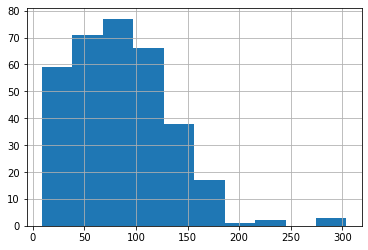

In [ ]:
news['org-spanish-tweets'].str.len().hist()

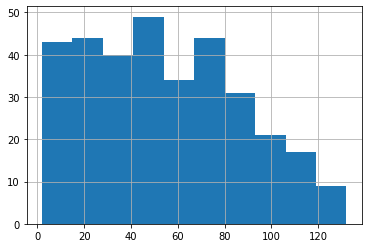

In [ ]:
df_tweets['google_stop'].map(lambda x: len(x)).hist()

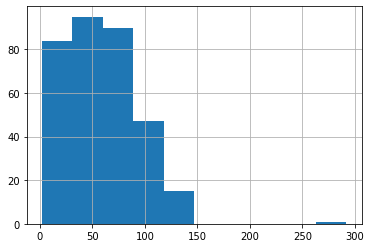

In [ ]:
df_tweets['opusmt_stop'].map(lambda x: len(x)).hist()

### **Word Count for original Spanish tweets**

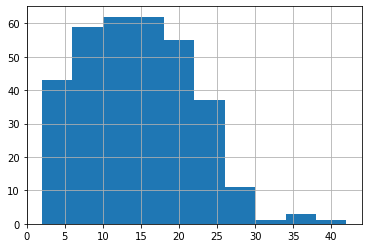

In [ ]:
news['org-spanish-tweets'].str.split().map(lambda x: len(x)).hist()

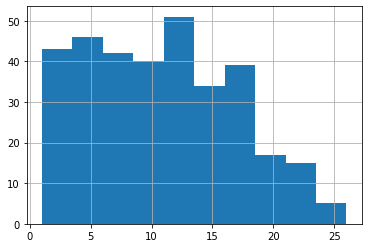

In [ ]:
df_tweets['google_stop'].str.split().map(lambda x: len(x)).hist()

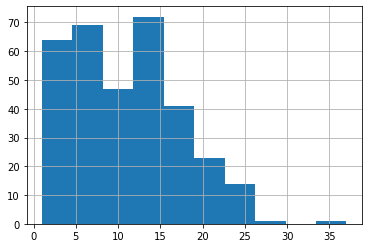

In [ ]:
df_tweets['opusmt_stop'].str.split().map(lambda x: len(x)).hist()

## **Stop words count in corpus**

In [ ]:
corpusG=[]
newG= df_tweets['google_stop'].str.split()
newO= df_tweets['opusmt_stop'].str.split()
#new=newG.values.tolist()+newO.values.tolist()
corpusG=[word for i in newG for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpusG:
    if word in stopwords_set:
        dic[word]+=1
        

<BarContainer object of 10 artists>

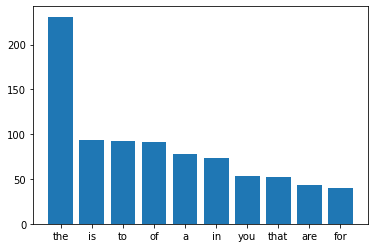

In [ ]:
import matplotlib.pyplot as plt
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

In [ ]:
corpusO=[]
corpusO=[word for i in newO for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpusO:
    if word in stopwords_set:
        dic[word]+=1
        

<BarContainer object of 10 artists>

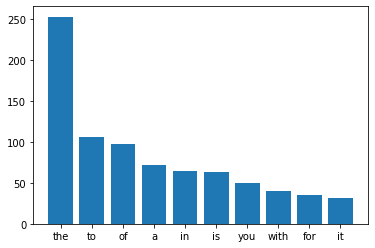

In [ ]:
import matplotlib.pyplot as plt
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

## **Word cloud generation for both translations**

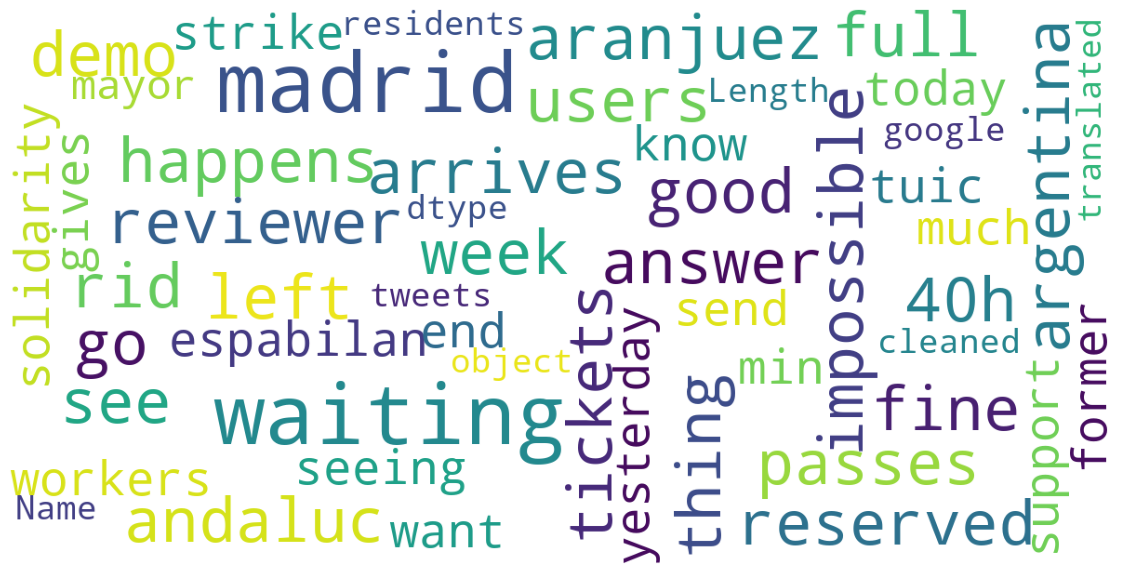

In [ ]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud1=wordcloud.generate(str(df_tweets['google-translated-cleaned-tweets']))

    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')

    plt.imshow(wordcloud1)

    plt.show()

show_wordcloud(corpusG)

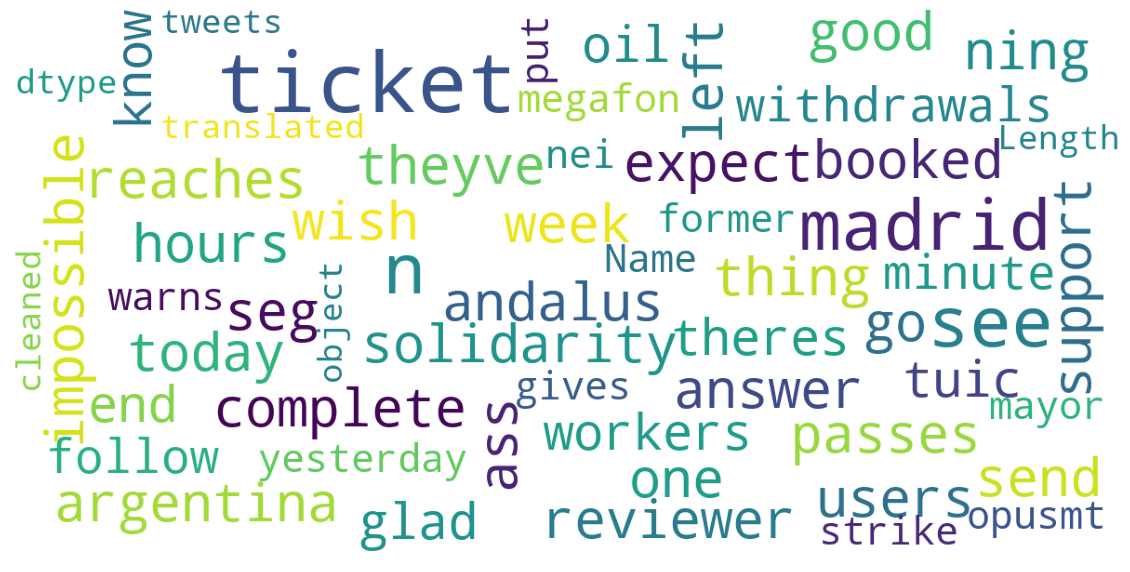

In [ ]:
def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud2=wordcloud.generate(str(df_tweets['opusmt-translated-cleaned-tweets']))

    fig = plt.figure(1, figsize=(20, 20))
    plt.axis('off')

    plt.imshow(wordcloud2)

    plt.show()

show_wordcloud(corpusO)

### **Scatterplots for polarity**

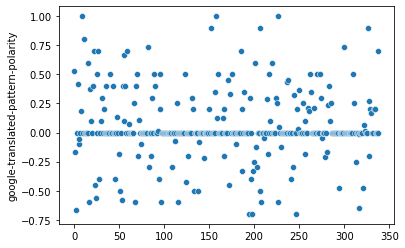

In [ ]:
sns.scatterplot(x=df_tweets.index,y=df_tweets['google-translated-pattern-polarity'])

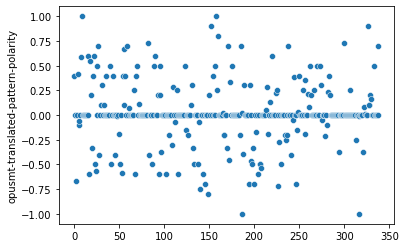

In [ ]:
sns.scatterplot(x=df_tweets.index,y=df_tweets['opusmt-translated-pattern-polarity'])

## **Swarm plot for polarity scores**

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 32.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


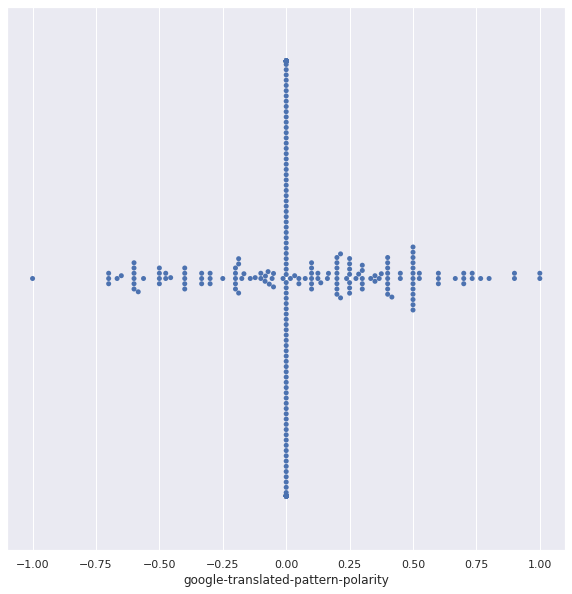

In [ ]:
import seaborn as sns
from collections import Counter
sns.set(rc={'figure.figsize':(10,10)})
sns.swarmplot (x=df_tweets['google-translated-pattern-polarity'])

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 30.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


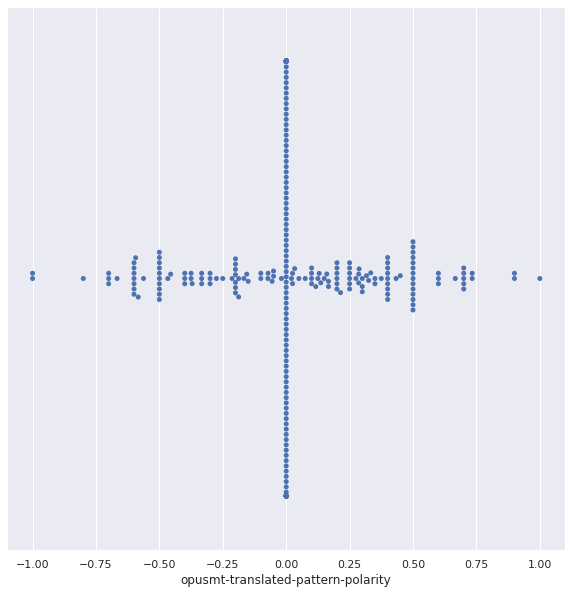

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.swarmplot (x=df_tweets['opusmt-translated-pattern-polarity'])

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 32.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


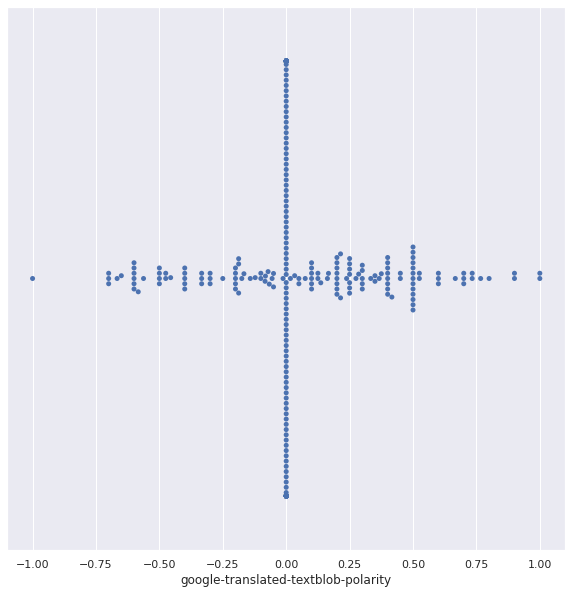

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.swarmplot (x=df_tweets['google-translated-textblob-polarity'])

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 30.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


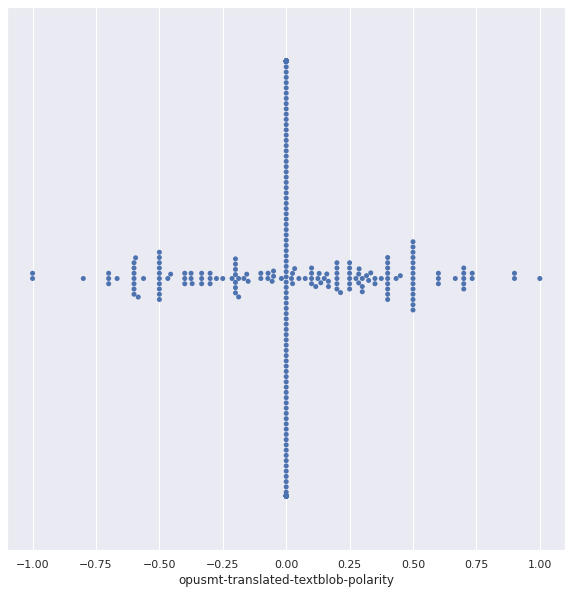

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.swarmplot (x=df_tweets['opusmt-translated-textblob-polarity'])

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 23.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


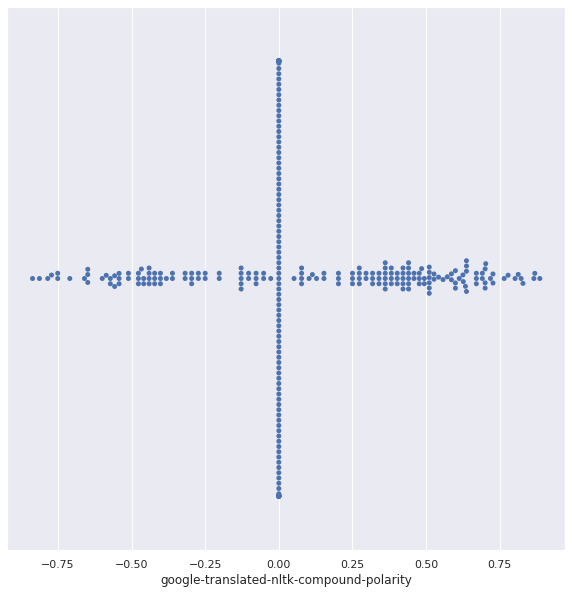

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.swarmplot (x=df_tweets['google-translated-nltk-compound-polarity'])

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:1296: UserWarning: 15.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


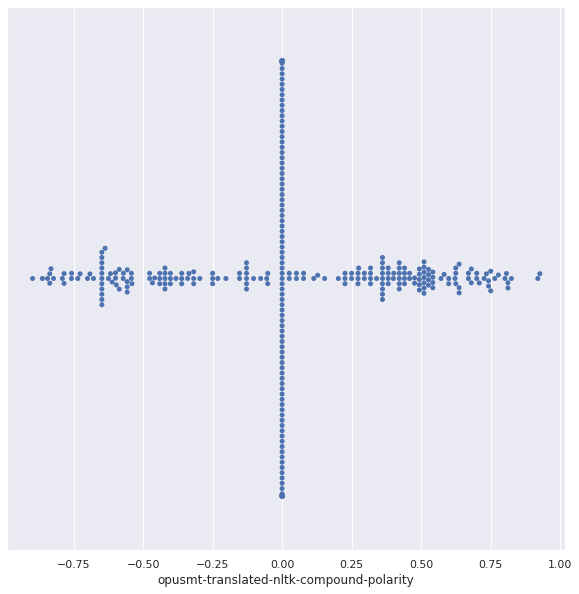

In [ ]:
sns.set(rc={'figure.figsize':(10,10)})
sns.swarmplot (x=df_tweets['opusmt-translated-nltk-compound-polarity'])

## **Confusion Matrix**

In [ ]:
import shutil
colab_link = "/content/sentimentanalysis_renfe.xlsx"
gdrive_link = "/content/sample_data"
shutil.copy(colab_link, gdrive_link)

'/content/sample_data/sentimentanalysis_renfe.xlsx'

In [ ]:
senti= pd.read_excel('/content/sample_data/sentimentanalysis_renfe.xlsx')
senti
col_list=['google-translated-textblob-polarity','google-translated-nltk-compound-polarity','google-translated-pattern-polarity','opusmt-translated-textblob-polarity','opusmt-translated-nltk-compound-polarity','opusmt-translated-pattern-polarity']
for row in range(len(senti)):
  for col in col_list: 
      if senti[col][row] <0:
          senti[col][row]=-1
      elif senti[col][row]==0:
          senti[col][row]=0
      elif senti[col][row]>0:
          senti[col][row]=1

<ipython-input-61-9ca171ac36d0>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti[col][row]=1
<ipython-input-61-9ca171ac36d0>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti[col][row]=0
<ipython-input-61-9ca171ac36d0>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  senti[col][row]=-1


In [ ]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(news['gold-score'],senti['google-translated-textblob-polarity'])
array

array([[23, 63, 21],
       [24, 85, 25],
       [ 8, 42, 41]])

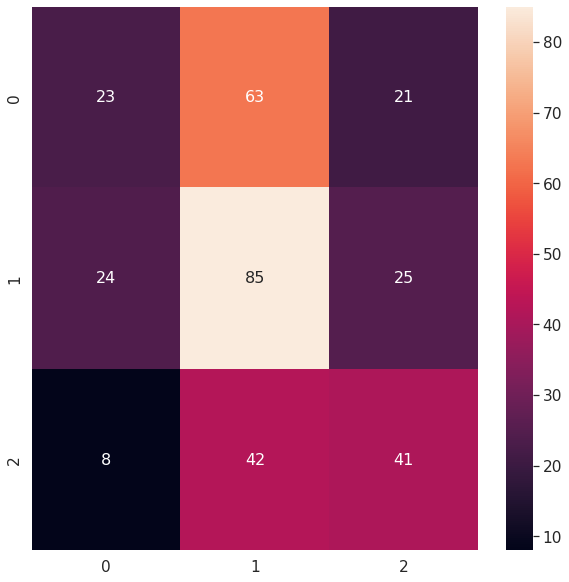

In [ ]:
df_cm = pd.DataFrame(array, range(3), range(3))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(news['gold-score'],senti['google-translated-nltk-compound-polarity'])
array

array([[37, 47, 23],
       [21, 80, 33],
       [ 7, 35, 49]])

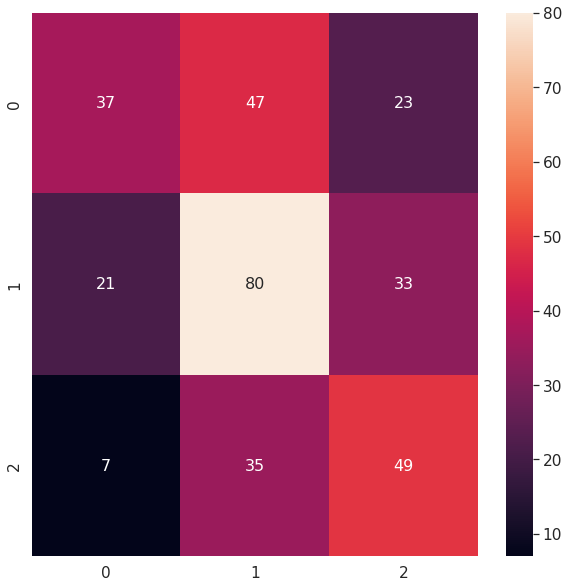

In [ ]:
df_cm = pd.DataFrame(array, range(3), range(3))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
#from sklearn.metrics import confusion_matrix
array = confusion_matrix(news['gold-score'],senti['google-translated-pattern-polarity'])
array

array([[23, 63, 21],
       [24, 85, 25],
       [ 8, 42, 41]])

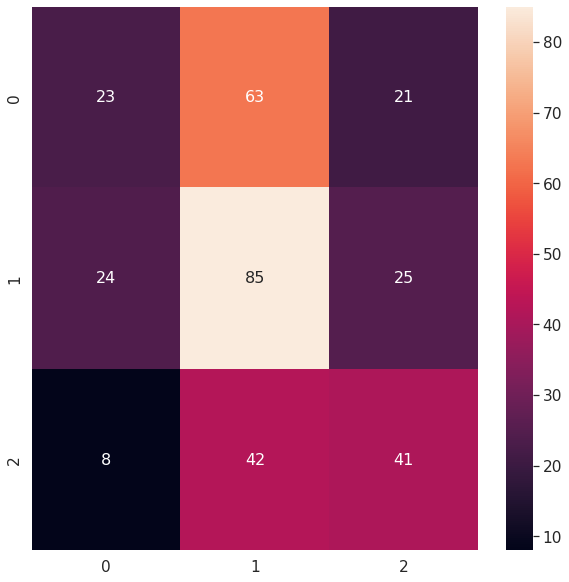

In [ ]:
df_cm = pd.DataFrame(array, range(3), range(3))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

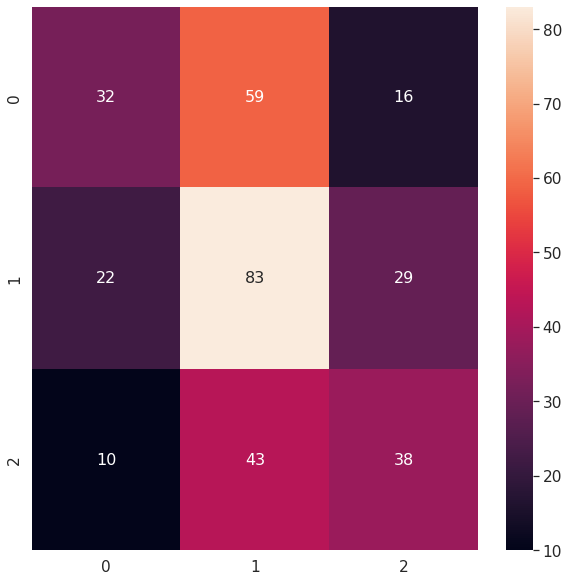

In [ ]:
array = confusion_matrix(news['gold-score'],senti['opusmt-translated-textblob-polarity'])
df_cm = pd.DataFrame(array, range(3), range(3))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

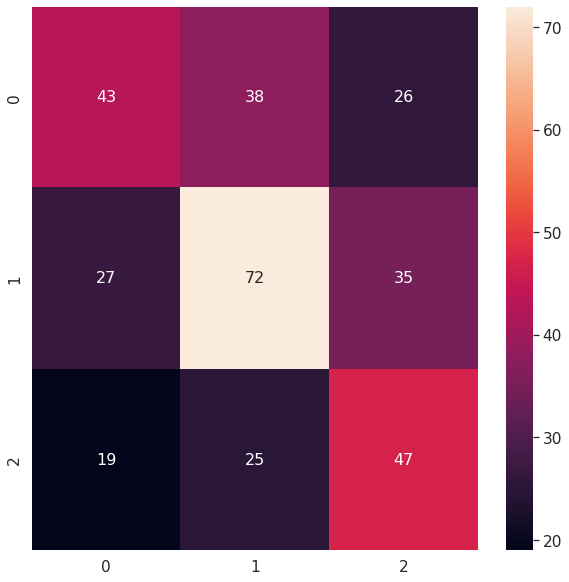

In [ ]:
array = confusion_matrix(news['gold-score'],senti['opusmt-translated-nltk-compound-polarity'])
df_cm = pd.DataFrame(array, range(3), range(3))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

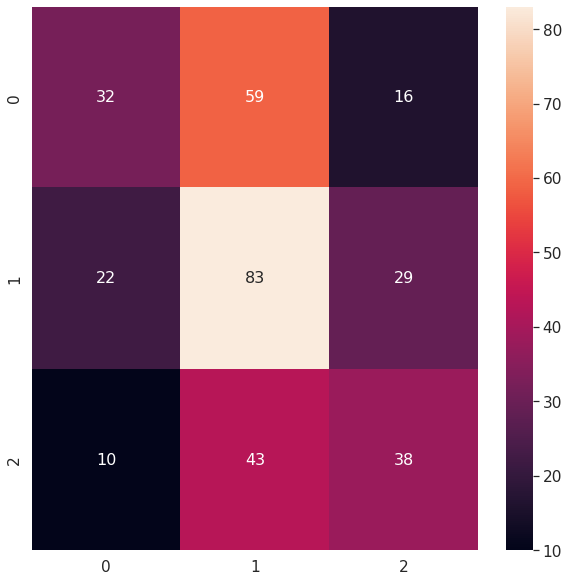

In [ ]:
array = confusion_matrix(news['gold-score'],senti['opusmt-translated-pattern-polarity'])
df_cm = pd.DataFrame(array, range(3), range(3))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size

plt.show()

## **To find the proportion of sentiments**

In [ ]:
news= pd.read_excel('/content/sample_data/sentimentanalysis_renfe.xlsx',nrows=len(gtrans_res))
news

,Unnamed: 0,org-spanish-tweets,google_stop,opusmt_stop,opusmt-translated-cleaned-tweets,google-translated-cleaned-tweets,word-count,google-translated-textblob-polarity,google-translated-nltk-compound-polarity,google-translated-pattern-polarity,opusmt-translated-textblob-polarity,opusmt-translated-nltk-compound-polarity,opusmt-translated-pattern-polarity
0,0,buenos en el tren de las 5 40h seg n completo ...,Good on the 5 40h and full train for a week,good on the train of 5 40 hours seg n complete...,good 5 40 hours seg n complete week,good 5 40h full week,15,0.525000,0.4404,0.525000,0.400000,0.4404,0.400000
1,1,lo le respondes este los dem ue te han dejado ...,You answer this the demo have left you in rid,You answer this one. They've left you in the ass.,answer one theyve left ass,answer demo left rid,13,0.000000,0.0000,0.000000,0.000000,-0.5423,0.000000
2,2,pero c mo lo hacen en argentina ocurre lo mism...,But as the same thing happens in Argentina it ...,But how they do it in Argentina the same thing...,argentina thing impossible get tickets,thing happens argentina impossible get tickets,16,-0.666667,0.0000,-0.666667,-0.666667,0.0000,-0.666667
3,3,si es de madrid andaluc pasa ning n revisor ha...,"If it is from Madrid Andaluc, no reviewer pass...",if it is madrid andalus passes ning n reviewer...,madrid andalus passes ning n reviewer reaches ...,madrid andaluc reviewer passes aranjuez arrives,12,0.000000,0.0000,0.000000,0.000000,0.0516,0.000000
4,4,una multa los usuarios hayan reservado vayan e...,A fine The users have reserved go on the train...,a ticket the users have booked go on the train...,ticket users booked go see expect,fine users reserved go see espabilan,14,0.416667,0.2023,0.416667,0.000000,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,327,hoy uiero mandar toda mi solidaridad apoyo los...,Today I want to send all my solidarity support...,Today I wish to send all my solidarity support...,today wish send solidarity support workers madrid,today want send solidarity support workers madrid,12,0.000000,0.6369,0.000000,0.000000,0.7650,0.000000
328,328,sabes lo mucho ue alegro,You know how much I am,You know how glad I am.,know glad,know much,5,0.200000,0.0000,0.200000,0.500000,0.4588,0.500000
329,329,hay hay ver si aceis el tuic al final lo,There are seeing if you do the tuic in the end,There's to see if you oil the tuic at the end,theres see oil tuic end,seeing tuic end,10,0.000000,0.0000,0.000000,0.000000,0.0000,0.000000
330,330,r yo de las subsanaciones de 40 min de espera ...,R I of the 40 min waiting for the waiting,I of the 40-minute withdrawals follow the mega...,40 minute withdrawals follow megafon warns put...,r 40 min waiting waiting,21,0.000000,0.0000,0.000000,0.000000,-0.1027,0.000000


<BarContainer object of 3 artists>

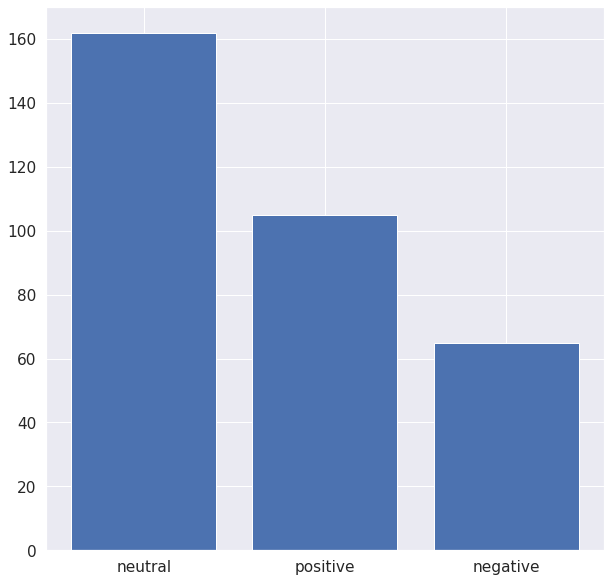

In [ ]:
import matplotlib.pyplot as plt

def sentiment(x):
    if x<0:
        return 'negative'
    elif x==0:
        return 'neutral'
    else:
        return 'positive'

news['polarity']=news['google-translated-nltk-compound-polarity'].map(lambda x: sentiment(x))
fig = plt.figure(1, figsize=(10, 10))

plt.bar(news.polarity.value_counts().index,
        news.polarity.value_counts())

<BarContainer object of 3 artists>

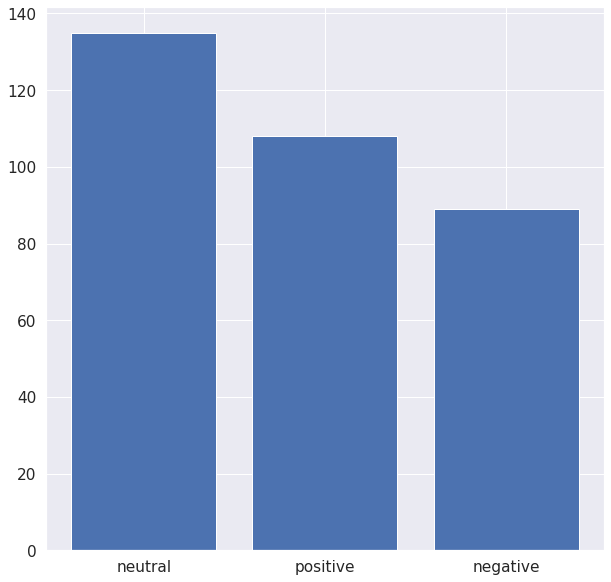

In [ ]:
import matplotlib.pyplot as plt

def sentiment(x):
    if x<0:
        return 'negative'
    elif x==0:
        return 'neutral'
    else:
        return 'positive'

news['polarity']=news['opusmt-translated-nltk-compound-polarity'].map(lambda x: sentiment(x))
fig = plt.figure(1, figsize=(10, 10))

plt.bar(news.polarity.value_counts().index,
        news.polarity.value_counts())

In [ ]:
vio= pd.read_excel('/content/sentimentanalysis_renfe_lengths.xlsx',nrows=len(gtrans_res))
vio

,Unnamed: 0,org-spanish-tweets,google_stop,opusmt_stop,opusmt-translated-cleaned-tweets,google-translated-cleaned-tweets,word-count,google-translated-textblob-polarity,google-translated-nltk-compound-polarity,google-translated-pattern-polarity,opusmt-translated-textblob-polarity,opusmt-translated-nltk-compound-polarity,opusmt-translated-pattern-polarity
0,0,buenos en el tren de las 5 40h seg n completo ...,Good on the 5 40h and full train for a week,good on the train of 5 40 hours seg n complete...,good 5 40 hours seg n complete week,good 5 40h full week,15,0.525000,0.4404,0.525000,0.400000,0.4404,0.400000
1,2,pero c mo lo hacen en argentina ocurre lo mism...,But as the same thing happens in Argentina it ...,But how they do it in Argentina the same thing...,argentina thing impossible get tickets,thing happens argentina impossible get tickets,16,-0.666667,0.0000,-0.666667,-0.666667,0.0000,-0.666667
2,6,trenes comprados de segunda mano espa en extra...,SECOND HAND BUY TRANES IN EXTRA CONDITION UE H...,trains bought second hand spa in extra conditi...,bought second hand spa extra conditions half f...,second hand buy tranes extra condition ue half...,16,-0.055556,0.4939,-0.055556,-0.055556,0.4939,-0.055556
3,9,las puertas de techo piso funcionan en el de m...,Floor roof doors work in Madrid seems an excel...,the floor ceiling doors work in the madrid one...,floor ceiling doors work madrid one seems exce...,floor roof doors work madrid seems excellent o...,15,1.000000,0.5719,1.000000,1.000000,0.5719,1.000000
4,13,hombre es para joder es para darse el gustazo ...,man is to fuck it is to like to travel for fre...,Man is to fuck is to like to travel for free w...,man fuck like travel free without moving house...,man fuck like travel free without moving home ...,22,0.000000,0.3182,0.000000,0.000000,0.3182,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,320,al llegar ah cual fue nuestra sorpresa ue ya e...,When it came to which was our surprise that th...,When we arrived ah what was our surprise ue al...,arrived ah surprise ue already exists n n type...,came surprise type cafeter restaurant,16,0.000000,0.2732,0.000000,0.000000,0.2732,0.000000
104,322,las vistas est n chulas el trayecto tampoco pu...,"The views are cool, the journey can either can...",The views are cool the route can not stretch m...,views cool route stretch much either cabins peue,views cool journey either stretch much cabins,16,0.275000,0.3182,0.275000,0.275000,0.3182,0.275000
105,325,hay bar en la terminal de la casa de campo ni ...,There is a bar at the country house terminal o...,There's a bar in the country house terminal. N...,theres bar country house terminal decent place...,bar country house terminal decent site sit,16,0.166667,0.0000,0.166667,0.166667,0.0000,0.166667
106,330,r yo de las subsanaciones de 40 min de espera ...,R I of the 40 min waiting for the waiting,I of the 40-minute withdrawals follow the mega...,40 minute withdrawals follow megafon warns put...,r 40 min waiting waiting,21,0.000000,0.0000,0.000000,0.000000,-0.1027,0.000000


<BarContainer object of 3 artists>

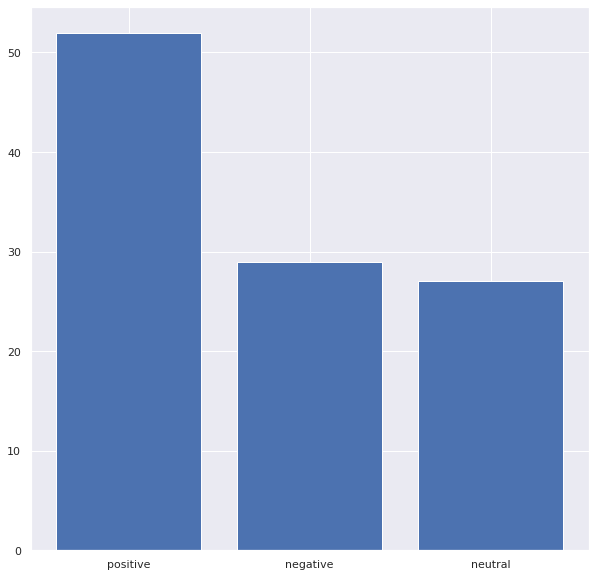

In [ ]:
vio['polarity']=vio['opusmt-translated-nltk-compound-polarity'].map(lambda x: sentiment(x))
fig = plt.figure(1, figsize=(10, 10))

plt.bar(vio.polarity.value_counts().index,
        vio.polarity.value_counts())